In [1]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, f1_score, recall_score
import numpy as np
import pandas as pd

In [3]:
from google.colab import files
uploaded = files.upload()


Saving fake_job_postings.csv to fake_job_postings.csv


In [4]:
# Load dataset
df = pd.read_csv("fake_job_postings.csv")

# Define features and target
X = df.drop(columns=["fraudulent"])
y = df["fraudulent"]

In [5]:
# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=["object"]).columns
numerical_features = X.select_dtypes(exclude=["object"]).columns

In [6]:
# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=2000))
    ])

In [7]:
# Define hyperparameter grid
grid_params = {
    'classifier__C': [0.01, 0.1, 1, 10],  # Regularization strength
    'classifier__penalty': ['l1', 'l2'],  # Regularization type
    'classifier__solver': ['liblinear', 'saga'],  # Solvers that support l1 & l2
    'classifier__class_weight': [None, 'balanced'],
}

# Define custom scoring metric
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'recall': make_scorer(recall_score)
    }

In [8]:
# Define custom scoring metric
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'recall': make_scorer(recall_score)
}

# Grid search with dataset splitting variations
split_ratios = [(0.6, 0.2, 0.2), (0.7, 0.15, 0.15), (0.8, 0.1, 0.1)]
best_model = None
best_score = -np.inf
best_split = None

In [9]:
LogisticRegression(C=10, class_weight='balanced', max_iter=2000, penalty='l1', solver='saga')



LogisticRegression(C=10, class_weight='balanced', max_iter=2000, penalty='l1',
                   solver='saga')

In [10]:
for train_size, val_size, test_size in split_ratios:
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, stratify=y, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size / (val_size + test_size), stratify=y_temp, random_state=42)

    grid_search = GridSearchCV(pipeline, grid_params, scoring=scoring, refit='f1', cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    if grid_search.best_score_ > best_score:
        best_model = grid_search.best_estimator_
        best_score = grid_search.best_score_
        best_split = (train_size, val_size, test_size)

print(f"Best Split Ratio: {best_split}")
print(f"Best Model Parameters: {best_model.named_steps['classifier']}")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Split Ratio: (0.7, 0.15, 0.15)
Best Model Parameters: LogisticRegression(C=10, class_weight='balanced', max_iter=2000, penalty='l1',
                   solver='liblinear')


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [11]:
y_val_pred = best_model.predict(X_val)

from sklearn.metrics import accuracy_score, classification_report
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))


Validation Accuracy: 0.9832214765100671
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1701
           1       0.91      0.72      0.81        87

    accuracy                           0.98      1788
   macro avg       0.95      0.86      0.90      1788
weighted avg       0.98      0.98      0.98      1788



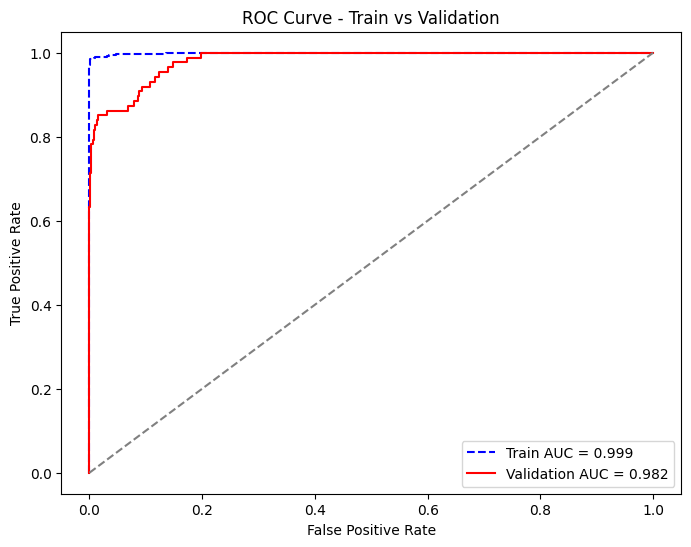

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get probability scores
y_train_probs = best_model.predict_proba(X_train)[:, 1]  # Probabilities for Class 1
y_val_probs = best_model.predict_proba(X_val)[:, 1]

# Compute ROC Curve & AUC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
auc_train = auc(fpr_train, tpr_train)
auc_val = auc(fpr_val, tpr_val)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc_train:.3f}", linestyle="--", color="blue")
plt.plot(fpr_val, tpr_val, label=f"Validation AUC = {auc_val:.3f}", linestyle="-", color="red")

# Random chance line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Train vs Validation")
plt.legend()
plt.show()


In [13]:
from sklearn.metrics import accuracy_score

# Compute accuracy
train_accuracy = accuracy_score(y_train, best_model.predict(X_train))
val_accuracy = accuracy_score(y_val, best_model.predict(X_val))

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


Training Accuracy: 0.9982
Validation Accuracy: 0.9832


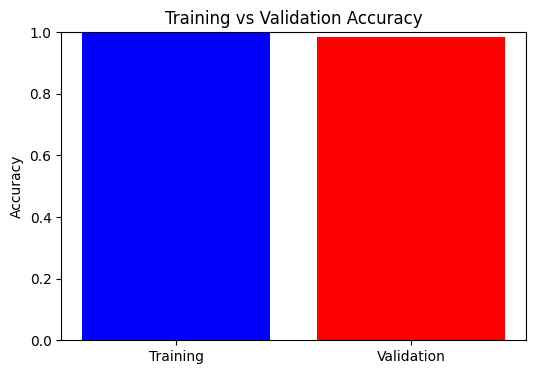

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Compute accuracy
train_accuracy = accuracy_score(y_train, best_model.predict(X_train))
val_accuracy = accuracy_score(y_val, best_model.predict(X_val))

# Plot bar chart
plt.figure(figsize=(6, 4))
plt.bar(["Training", "Validation"], [train_accuracy, val_accuracy], color=['blue', 'red'])
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.show()


In [15]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on test set
y_test_pred = best_model.predict(X_test)

# Compute accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print results
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))


Test Accuracy: 0.9883
Test Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1702
           1       0.99      0.77      0.86        86

    accuracy                           0.99      1788
   macro avg       0.99      0.88      0.93      1788
weighted avg       0.99      0.99      0.99      1788



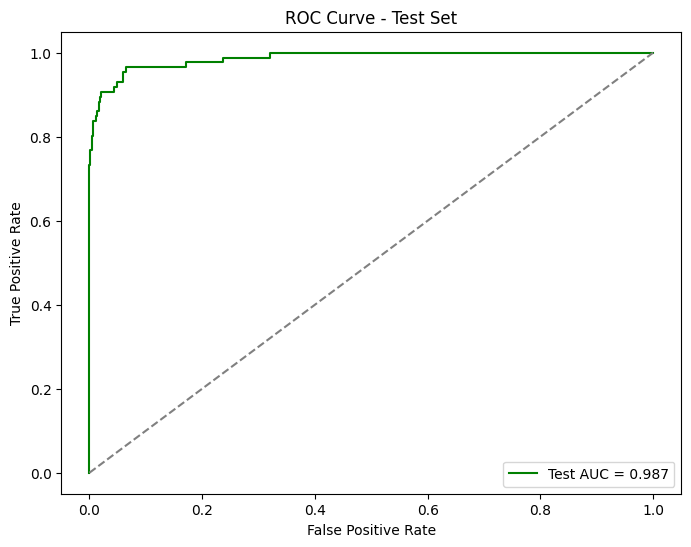

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get test probability scores
y_test_probs = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve & AUC
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)
auc_test = auc(fpr_test, tpr_test)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {auc_test:.3f}", color="green")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random chance line

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Set")
plt.legend()
plt.show()


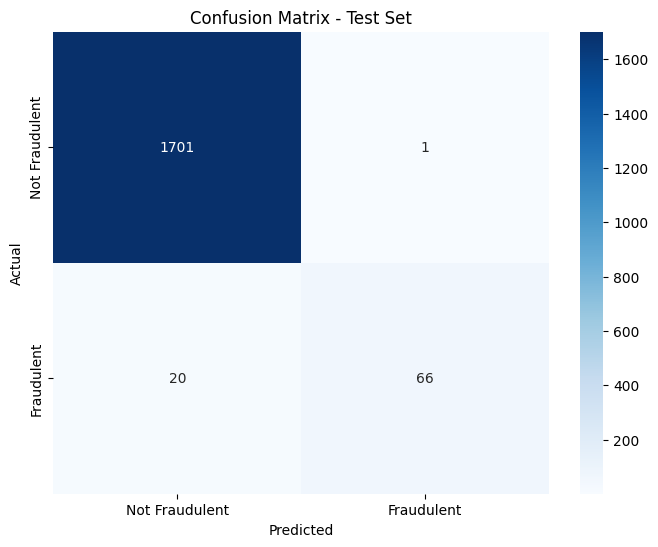

In [18]:
# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix for the test set
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraudulent', 'Fraudulent'], yticklabels=['Not Fraudulent', 'Fraudulent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.show()

In [19]:
pip install scikit-learn nltk


In [20]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import string

# Load your dataset
df = pd.read_csv("fake_job_postings.csv")
print(df.columns)



Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')


In [23]:
texts = df['description']
labels = df['fraudulent']

In [25]:
# Drop rows where text is NaN
texts = df['description'].dropna()

df = df.dropna(subset=['description', 'fraudulent'])
labels = df['fraudulent']

texts = df['description'].fillna('')


In [27]:
import nltk
nltk.data.path.append('/root/nltk_data')


In [28]:
# Text preprocessing and Vectorization
import re
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

def custom_tokenizer(text):
    # Lowercase + tokenize using regex
    tokens = re.findall(r'\b\w+\b', text.lower())
    # Remove stopwords and non-alphabetic tokens
    return [t for t in tokens if t.isalpha() and t not in stop_words]


from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_features=5000)
X = vectorizer.fit_transform(texts)


# Apply TF-IDF
X = vectorizer.fit_transform(texts)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [29]:
# Split and train
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Train SVM
svm = LinearSVC()
svm.fit(X_train, y_train)

# Evaluate
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3394
           1       0.92      0.59      0.72       182

    accuracy                           0.98      3576
   macro avg       0.95      0.80      0.86      3576
weighted avg       0.98      0.98      0.97      3576



In [30]:
# To combat Class imbalance
pip install imbalanced-learn


In [31]:
# Define features (X) and target (y)
X = df['description']  # or whichever column has the job text
y = df['fraudulent'] # target labels: 0 = real, 1 = fake


In [32]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [33]:
# Build the Pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(class_weight='balanced'))
])

In [34]:
#  ReTrain the model
pipeline.fit(X_train, y_train)

#  Predict and evaluate
from sklearn.metrics import classification_report
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.95      0.73      0.82       173

    accuracy                           0.98      3576
   macro avg       0.97      0.86      0.91      3576
weighted avg       0.98      0.98      0.98      3576



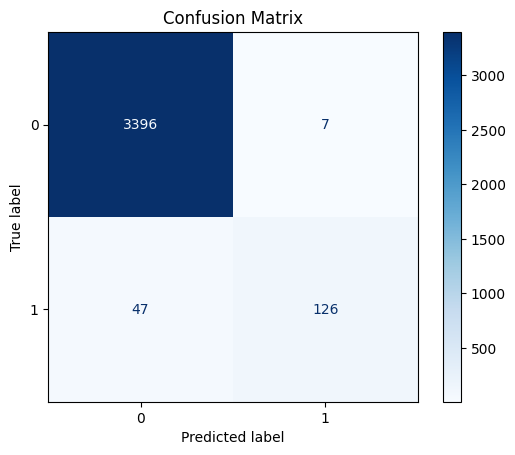

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions
y_pred = pipeline.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()


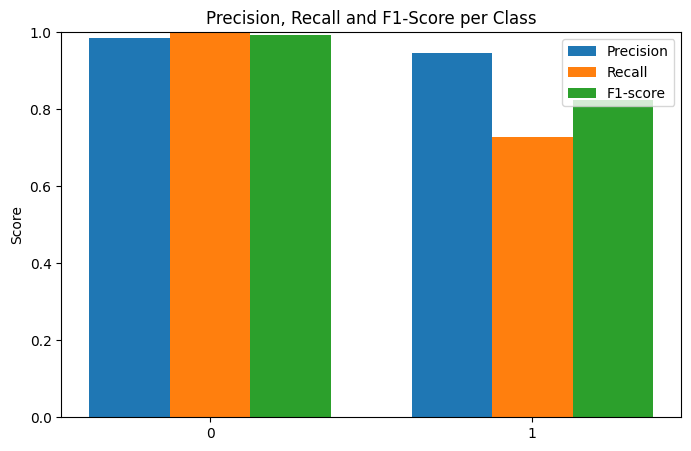

In [36]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# Get precision, recall, f1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred)

labels = pipeline.classes_

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(8,5))

ax.bar(x - width, precision, width, label='Precision')
ax.bar(x, recall, width, label='Recall')
ax.bar(x + width, f1, width, label='F1-score')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0,1])
ax.set_ylabel('Score')
ax.set_title('Precision, Recall and F1-Score per Class')
ax.legend()

plt.show()


In [37]:
# SVM DOES NOT PROVIDE PROBABILITY SO I ENABLE PROBABILITY
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(class_weight='balanced', probability=True))
])


In [38]:
# Retraining the model for me to be able to calculate accuracy
pipeline.fit(X_train, y_train)


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('svm', SVC(class_weight='balanced', probability=True))])

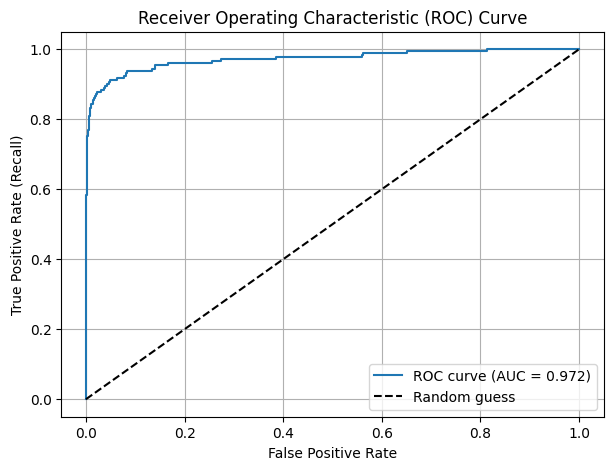

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
y_scores = pipeline.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [40]:
!pip install scikit-learn==1.3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 56.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [7]:
import pandas as pd

# Load the dataset
df = pd.read_csv("fake_job_postings.csv")

# Optional: check columns
print(df.columns)
df.head()


Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')


job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   
1  Organised - Focused - Vibrant - Awesome!Do you...   
2  Our client, located in Houston, is actively se...   
3  THE COMPANY: ESRI – Environmental Systems Rese...   
4  JOB TITLE: Itemization Review ManagerLOCATION:...   

                                        requirements  \
0  Experience with content management systems a m...   
1  What we expect from you:Your key responsibilit...   
2  Implement pre-commissioning and commissioning ...   
3  EDUCATION: Bachelor’s or Master’s in GIS, busi...   
4  QUALIFICATIONS:RN license in the State of Texa...   

                                            benefits  telecommuting  \
0                                                NaN              0   
1  What you will get from usThrough being part of...              0   
2                                                NaN              0   
3  Our culture is anything but corporate—we have ...              0   
4                              Full Benefits Offered              0   

   has_company_logo  has_questions employment_type required_experience  \
0                 1              0           Other          Internship   
1                 1              0       Full-time      Not Applicable   
2                 1              0             NaN                 NaN   
3                 1              0       Full-time    Mid-Senior level   
4                 1              1       Full-time    Mid-Senior level   

  required_education                   industry              function  \
0                NaN                        NaN             Marketing   
1                NaN  Marketing and Advertising      Customer Service   
2                NaN                        NaN                   NaN   
3  Bachelor's Degree          Computer Software                 Sales   
4  Bachelor's Degree     Hospital & Health Care  Health Care Provider   

   fraudulent  
0           0  
1           0  
2           0  
3           0  
4           0

In [9]:
X_text = df['description']
y = df['fraudulent']


In [10]:
from sklearn.model_selection import train_test_split

# Text and target
X_text = df['description']
y = df['fraudulent']

# Structured features (drop text and target)
X_structured = df.drop(columns=['description', 'fraudulent'])

# Train-test split
X_train_text, X_test_text, X_train_structured, X_test_structured, y_train, y_test = train_test_split(
    X_text, X_structured, y, test_size=0.2, random_state=42
)


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Identify feature types
numerical_features = ['has_company_logo', 'telecommuting']
categorical_features = ['location', 'employment_type', 'required_experience']

# Build preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Transform training and test structured data
X_train_numerical = preprocessor.fit_transform(X_train_structured)
X_test_numerical = preprocessor.transform(X_test_structured)


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report # Import classification_report

# Logistic Regression (on numerical/categorical)
logreg_bagging = BaggingClassifier(
    base_estimator=LogisticRegression(max_iter=1000),
    n_estimators=10,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
logreg_bagging.fit(X_train_numerical, y_train)

# Replace NaN values with an empty string
X_train_text = X_train_text.fillna('')
X_test_text = X_test_text.fillna('')

# Then transform using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_text_transformed = tfidf_vectorizer.fit_transform(X_train_text)
X_test_text_transformed = tfidf_vectorizer.transform(X_test_text)


print(X_train_text.isnull().sum())
print(X_test_text.isnull().sum())



# Vectorize
tfidf_vectorizer = TfidfVectorizer()
X_train_text_transformed = tfidf_vectorizer.fit_transform(X_train_text.fillna(''))
X_test_text_transformed = tfidf_vectorizer.transform(X_test_text.fillna(''))

# Make writable and dense if needed
X_train_text_transformed = X_train_text_transformed.copy().tocsr()

# Bagging Classifier
svm_bagging = BaggingClassifier(
    estimator=SVC(kernel='linear'),
    n_estimators=10,
    n_jobs=1,
    random_state=42
)

# Fit model
svm_bagging.fit(X_train_text_transformed, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0
0


BaggingClassifier(estimator=SVC(kernel='linear'), n_jobs=1, random_state=42)

In [18]:
# Predictions for Logistic Regression Bagging model
y_pred_logreg_bagging = logreg_bagging.predict(X_test_numerical)

# Predictions for SVM Bagging model
y_pred_svm_bagging = svm_bagging.predict(X_test_text_transformed)

In [19]:
from sklearn.metrics import classification_report

# Evaluation for Logistic Regression Bagging model
print("Classification Report for Logistic Regression Bagging:")
print(classification_report(y_test, y_pred_logreg_bagging))

# Evaluation for SVM Bagging model
print("\nClassification Report for SVM Bagging:")
print(classification_report(y_test, y_pred_svm_bagging))

Classification Report for Logistic Regression Bagging:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3395
           1       0.71      0.15      0.25       181

    accuracy                           0.95      3576
   macro avg       0.83      0.57      0.61      3576
weighted avg       0.94      0.95      0.94      3576


Classification Report for SVM Bagging:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3395
           1       0.98      0.49      0.65       181

    accuracy                           0.97      3576
   macro avg       0.98      0.75      0.82      3576
weighted avg       0.97      0.97      0.97      3576



In [20]:
from sklearn.metrics import accuracy_score

# Accuracy for Logistic Regression Bagging model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg_bagging)
print(f"Accuracy for Logistic Regression Bagging: {accuracy_logreg:.4f}")

# Accuracy for SVM Bagging model
accuracy_svm = accuracy_score(y_test, y_pred_svm_bagging)
print(f"Accuracy for SVM Bagging: {accuracy_svm:.4f}")

Accuracy for Logistic Regression Bagging: 0.9539
Accuracy for SVM Bagging: 0.9737



Confusion Matrix for Logistic Regression Bagging:


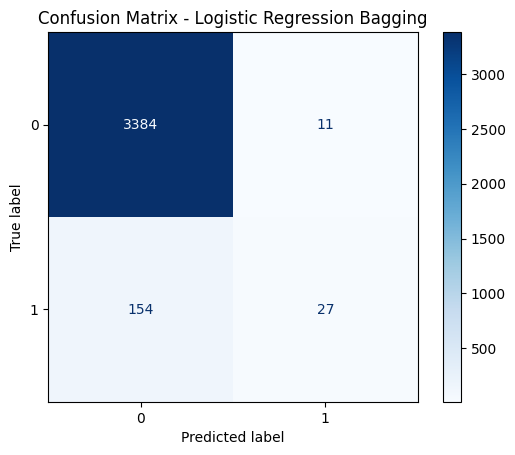


Confusion Matrix for SVM Bagging:


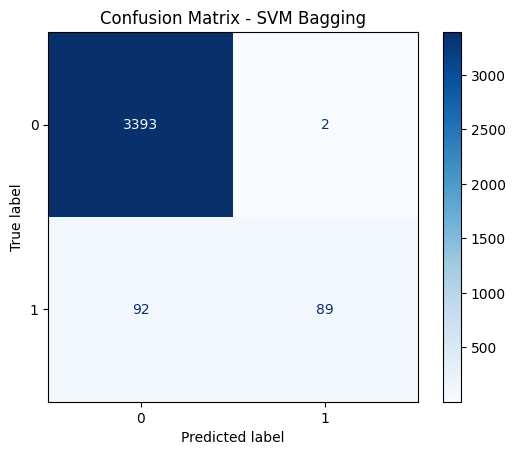

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix for Logistic Regression Bagging model
cm_logreg = confusion_matrix(y_test, y_pred_logreg_bagging)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=[0, 1]) # Assuming binary classification labels 0 and 1

print("\nConfusion Matrix for Logistic Regression Bagging:")
disp_logreg.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression Bagging")
plt.show()


# Confusion Matrix for SVM Bagging model
cm_svm = confusion_matrix(y_test, y_pred_svm_bagging)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=[0, 1]) # Assuming binary classification labels 0 and 1

print("\nConfusion Matrix for SVM Bagging:")
disp_svm.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - SVM Bagging")
plt.show()

In [24]:
# For a built stacked ensemble model
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


X_text = df['description']         # text feature
y = df['fraudulent']                   # target label
X_structured = df.drop(columns=['description', 'fraudulent'])

# Split data
X_train_text, X_test_text, X_train_structured, X_test_structured, y_train, y_test = train_test_split(
    X_text, X_structured, y, test_size=0.2, random_state=42
)

# Preprocessing pipeline for structured data
numerical_features = ['has_company_logo', 'telecommuting']
categorical_features = ['location', 'employment_type', 'required_experience']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X_train_num = preprocessor.fit_transform(X_train_structured)
X_test_num = preprocessor.transform(X_test_structured)

# Base estimators:
logreg = LogisticRegression(max_iter=1000)
svm_pipeline = make_pipeline(
    TfidfVectorizer(),
    SVC(kernel='linear', probability=True, random_state=42)
)

# Train base models individually
logreg.fit(X_train_num, y_train)

# Fill NaN values in X_train_text before fitting the SVM pipeline
svm_pipeline.fit(X_train_text.fillna(''), y_train)

# Get predicted probabilities as features for the meta-model:
logreg_probs_train = logreg.predict_proba(X_train_num)[:, 1].reshape(-1, 1)
svm_probs_train = svm_pipeline.predict_proba(X_train_text.fillna(''))[:, 1].reshape(-1, 1)

# Stack base model probabilities as new features
X_meta_train = np.hstack([logreg_probs_train, svm_probs_train])

# Define meta-model:
meta_model = LogisticRegression()

# Train meta-model on stacked base model outputs
meta_model.fit(X_meta_train, y_train)

# --- Predict on test set ---

logreg_probs_test = logreg.predict_proba(X_test_num)[:, 1].reshape(-1, 1)
# Fill NaN values in X_test_text before predicting with the SVM pipeline
svm_probs_test = svm_pipeline.predict_proba(X_test_text.fillna(''))[:, 1].reshape(-1, 1)
X_meta_test = np.hstack([logreg_probs_test, svm_probs_test])

# Final prediction from meta-model
y_pred = meta_model.predict(X_meta_test)

# Evaluate
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       0.89      0.65      0.75       181

    accuracy                           0.98      3576
   macro avg       0.93      0.82      0.87      3576
weighted avg       0.98      0.98      0.98      3576



In [26]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=e17f9a27088a322be837453827571cf13fdb1a90c4d7eb587814dbe4cd705033
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [27]:
# Using LIME for MODEL DECISION EXPLANATION
import lime
import lime.lime_tabular
import numpy as np

# Prepare the feature names for meta-model input
feature_names = ['LogReg_prob', 'SVM_prob']

# Create LIME explainer for tabular data
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_meta_train,
    feature_names=feature_names,
    class_names=['Non-fraud', 'Fraud'],
    mode='classification'
)

# Pick an instance index to explain
i = 10  # change as you like

# Explain prediction for that instance
exp = explainer.explain_instance(
    data_row=X_meta_test[i],
    predict_fn=meta_model.predict_proba
)

# Show explanation in notebook
exp.show_in_notebook(show_table=True)


In [28]:
from lime.lime_text import LimeTextExplainer

# Explainer for text data
text_explainer = LimeTextExplainer(class_names=['Non-fraud', 'Fraud'])

# Explain prediction on single example text
idx = 10  # example index
exp_text = text_explainer.explain_instance(
    X_test_text.iloc[idx],
    svm_pipeline.predict_proba,
    num_features=10
)

exp_text.show_in_notebook(text=True)


In [30]:
import numpy as np

# Example: get feature names from ColumnTransformer
def get_feature_names(column_transformer):
    feature_names = []

    for name, transformer, columns in column_transformer.transformers_:
        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(columns)
        else:
            names = columns
        feature_names.extend(names)
    return feature_names

feature_names = get_feature_names(preprocessor)
print(feature_names)


['has_company_logo', 'telecommuting', 'location_AE, , ', 'location_AE, , Abudhabi', 'location_AE, , Dubai', 'location_AE, , Media City | Dubai', 'location_AE, AZ, ', 'location_AE, AZ, Abudhabi', 'location_AE, DU, ', 'location_AE, DU, Dubai', 'location_AE, DU, Dubai Internet City', 'location_AE, DU, Dubayy', 'location_AL, 11, ', 'location_AM, , Yerevan', 'location_AM, ER, Yerevan', 'location_AR, , ', 'location_AT, , ', 'location_AT, 5, ', 'location_AT, 5, Salzburg', 'location_AT, 9, ', 'location_AT, 9, Vienna', 'location_AU', 'location_AU, , ', 'location_AU, , Australia', 'location_AU, , Sydney', 'location_AU, , Work from home', 'location_AU, ACT, ', 'location_AU, ACT, Canberra', 'location_AU, NSW, ', 'location_AU, NSW, 2010', 'location_AU, NSW, Artarmon', 'location_AU, NSW, Darlinghurst', 'location_AU, NSW, Newcastle ', 'location_AU, NSW, North Sydney', 'location_AU, NSW, South West Sydney and M5 corridor', 'location_AU, NSW, Surry Hills', 'location_AU, NSW, Sydney', 'location_AU, NSW,

In [31]:
feature_names = [f'f{i}' for i in range(X_train_num.shape[1])]


In [32]:
feature_names = [f'f{i}' for i in range(X_train_num.shape[1])]  # safe generic names

tabular_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_num if not hasattr(X_train_num, "toarray") else X_train_num.toarray(),
    feature_names=feature_names,
    class_names=['Non-fraud', 'Fraud'],
    mode='classification'
)

# Explain one instance
exp = tabular_explainer.explain_instance(
    data_row=X_test_num[0] if not hasattr(X_test_num, "toarray") else X_test_num.toarray()[0],
    predict_fn=logreg.predict_proba,
    num_features=10
)

exp.show_in_notebook(show_table=True)


In [33]:
def get_feature_names_from_column_transformer(column_transformer):
    """Extract feature names from ColumnTransformer."""
    feature_names = []

    for name, transformer, columns in column_transformer.transformers_:
        if name == 'remainder' and transformer == 'drop':
            continue

        # If transformer is a pipeline, get last step
        if hasattr(transformer, 'named_steps'):
            transformer = transformer.named_steps[list(transformer.named_steps)[-1]]

        # Get feature names from transformer if possible
        if hasattr(transformer, 'get_feature_names_out'):
            try:
                # Some transformers require input feature names
                names = transformer.get_feature_names_out(columns)
            except:
                # fallback if transformer does not accept input features
                names = transformer.get_feature_names_out()
            feature_names.extend(names)
        else:
            # If no get_feature_names_out, use column names as is (for numeric)
            if isinstance(columns, list):
                feature_names.extend(columns)
            else:
                feature_names.append(columns)

    return feature_names


In [34]:
feature_names = get_feature_names_from_column_transformer(preprocessor)
print(f"Total features after transform: {len(feature_names)}")
print("Sample features:", feature_names[:20])


Total features after transform: 2766
Sample features: ['has_company_logo', 'telecommuting', 'location_AE, , ', 'location_AE, , Abudhabi', 'location_AE, , Dubai', 'location_AE, , Media City | Dubai', 'location_AE, AZ, ', 'location_AE, AZ, Abudhabi', 'location_AE, DU, ', 'location_AE, DU, Dubai', 'location_AE, DU, Dubai Internet City', 'location_AE, DU, Dubayy', 'location_AL, 11, ', 'location_AM, , Yerevan', 'location_AM, ER, Yerevan', 'location_AR, , ', 'location_AT, , ', 'location_AT, 5, ', 'location_AT, 5, Salzburg', 'location_AT, 9, ']


In [35]:
tabular_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_num if not hasattr(X_train_num, "toarray") else X_train_num.toarray(),
    feature_names=feature_names,
    class_names=['Non-fraud', 'Fraud'],
    mode='classification'
)
